In [1]:
import os, sys, re
import numpy as np
import numpy.ma as ma
from math import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import fit_beta as fb
import scipy.special as ss
import bisect
from ipywidgets import *

In [2]:
def linfit(x,y):
    nn = ma.count(x)
    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
    return(c)

def interpolate(xx,yy,x,default=np.nan):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            w=(x-xx[i])/(xx[i+1]-xx[i])
            return (1.-w)*yy[i] + w*yy[i+1]    

<h3>Regressie HBV-to-SOBEK Rijn</h3>
Uit regressie is een relatie bepaald uit de HBV-(piek)afvoeren $Q_h$ en de bijbehorende Sobek (piek)afvoeren $Q_s$ als volgt (Henk vd Boogaard, <tt>regression_2018</tt>):
    $$Q_s\,=\,C\,+\,r_1Q_h\,+\,(r_2-r_1)\sigma_1\log\left(1+\exp\left(\frac{Q_h-\mu_1}{\sigma_1}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_3-r_2)\,\sigma_2\log\left(1+\exp\left(\frac{Q_h-\mu_2}{\sigma_2}\right)\right)$$    
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_4-r_3)\,\sigma_3\log\left(1+\exp\left(\frac{Q_h-\mu_3}{\sigma_3}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_5-r_4)\,\sigma_4\log\left(1+\exp\left(\frac{Q_h-\mu_4}{\sigma_4}\right)\right)$$

In [3]:
def regression_2018(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_


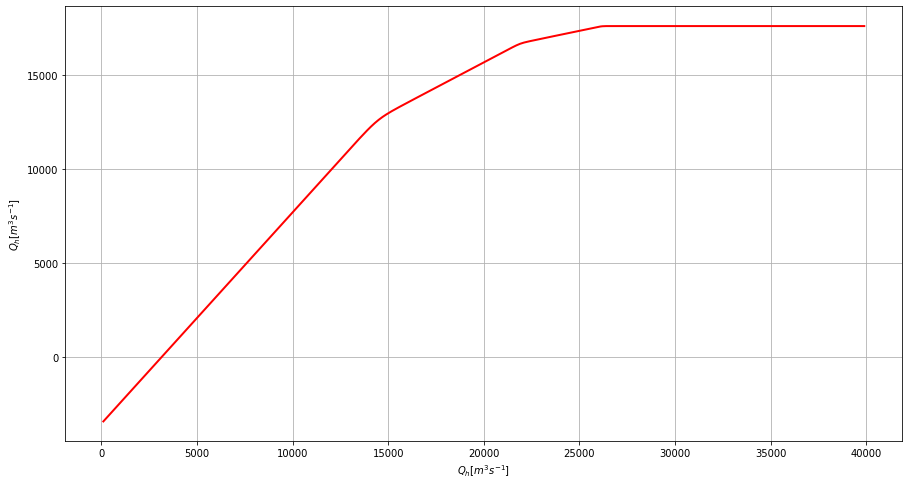

In [4]:
x = list(range(100,40000,100))
y = regression_2018(x)    
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x,y,'r-',linewidth=2.0)
# ax1.plot(x,x,'--')
max_sbk=max(y)
max_sbk
# ax1.plot(ax1.get_xlim(),[max_sbk,max_sbk],'r--')
xx=np.array(x)
ax1.grid()
xlbl = ax1.set_xlabel('$Q_h [m^3 s^{-1}]$')
ylbl = ax1.set_ylabel('$Q_h [m^3 s^{-1}]$')

We zoeken de dichtheid van $Q_s$, als $Q_h$ normaal verdeeld is.
I.h.a, als de invoer $x$ van de transformatie een dichtheid $f(x)$ heeft (en een verdeling $F(x)$), dan geldt
voor de dichtheid $g$ van de uitvoer $y(x)$:
$$
g(y) dy\,=\,f(x)dx
\hspace{2cm}
\rightarrow
\hspace{2cm}
g(y)\,=\,f\left(x(y)\right) \frac {dx}{dy}
$$

Dit veresit een voorschrift van $x$ als functie van $y$, dus in het bovenstaande geval de inverse van de transformatie van $Q_h$ naar $Q_s$ en ook de afgeleide van deze inverse $dQ_h/dQ_s$. Voor overzicht noteren we $Q_h=x$ en $Q_s=y$.


<b>Optie 1:</b>

Tabelleer de transformatie (tabel van $x$ versus $y$) en bepaal daaruit de afgeleide van de transformatie en zjin inverse.
Note: de transformatie is monotoon, dus bijectief, dus geldt:
        $$
        %\phantom{\left\vert}\frac {dx}{dy}\right\vert_{y}\,=\,
        \left[\frac {dx}{dy}\right]_{y}\,=\,
        \left[\frac {dy}{dx}\right]^{-1}_{x(y)}
        $$

In [5]:
#tabelleer de regressie:
x_hbv = np.array(list(range(100,40000,100)))
y_sbk = np.array(regression_2018(x_hbv))
dydx = {'x':(x_hbv[1:]+x_hbv[:-1])*0.5,'dydx':(y_sbk[1:]-y_sbk[:-1])/(x_hbv[1:]-x_hbv[:-1])}
dxdy = {'y':(y_sbk[1:]+y_sbk[:-1])*0.5,'dxdy':(x_hbv[1:]-x_hbv[:-1])/(y_sbk[1:]-y_sbk[:-1])}

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


<b>Optie 2:</b>
Bedenk een benadering die te inverteren is en waarvan de afgeleiden in beide richtingen eenvoudig zijn, bijvoorbeeld:

$$
y(x)\,=\,
\cases{
x<x_{th}:\hspace{1cm}K\,+\,(x-x_{th})\alpha \\
x>x_{th}:\hspace{1cm}M\left(1-A \exp\left(-(x/\sigma)^\gamma\right)\right) 
}
$$
En voor de afgeleide:

$$
\frac{\partial y}{\partial x}\,=\,
\cases{
x<x_{th}:\hspace{1cm}\alpha \\
x>x_{th}:\hspace{1cm}\frac{\gamma MA}\sigma (x/\sigma)^{\gamma-1} \exp\left(-(x/\sigma)^\gamma\right)
}
$$

Continu en continu differentiëerbaar in $x_{th}$:
$$
K\,=\,M\left(1-A \exp\left(-(x_{th}/\sigma)^\gamma\right)\right)  \\
\alpha\,=\,\frac{\gamma MA}\sigma (x_{th}/\sigma)^{\gamma-1} \exp\left(-(x_{th}/\sigma)^\gamma\right)
$$

Inverse:
$$
x(y)\,=\,
\cases{
y<K:\hspace{1cm}x_{th}\,+\,\frac 1 \alpha(y\,-\,K)\\
y>K:\hspace{1cm}\sigma\left(-\log\left(\frac 1 A \left[1\,-\,\frac y M\right]\right)\right)^{1/\gamma}
}
$$

Afgeleide van de inverse:
$$
\frac{\partial x}{\partial y}\,=\,
\cases{
y<K:\hspace{1cm}1/\alpha\\
y>K:\hspace{1cm}
\frac \sigma \gamma \left(-\log\left(\frac 1 A \left[1-\frac y M\right]\right)\right)^{1/\gamma-1}
\frac A {M-y}
}
$$

De afgeleide van de inverse gaat naar oneindig als $y\uparrow M$, de bovengrens van de transformatie.


In [6]:
# Vereenvoudigde benadering van de transformatie HBV naar Sobek
M = 17617.7
xxth = 12000
gamma = 1.5
A = 1.4
sigma = 10656

# Voorwaartse transformatie
def diff_forward_upper(xx):
    dydx=gamma*M*A/sigma*(xx/sigma)**(gamma-1)*np.exp(-(xx/sigma)**gamma)
    return dydx

def diff_forward(xx):
    if xx>xxth:
        dxdy=diff_forward_upper(xx)
    else:
        dxdy=diff_forward_upper(xxth)
    return dxdy
    
def forward_upper(xx):
    yy=M-A*M*np.exp(-(xx/sigma)**gamma)
    return yy

def forward(xx):
    if xx>xxth:
        yy=forward_upper(xx)
    else:
        yy=forward_upper(xxth)+(xx-xxth)*diff_forward_upper(xxth)
    return yy

In [7]:
yyth = forward(xxth)

# Inverse transformatie
def diff_inverse_upper(yy):
    dxdy=(sigma/gamma)*(-np.log(1./A*(1.-yy/M)))**(1./gamma-1.)*A/(M-yy)
    return dxdy

def diff_inverse(yy):
    if yy>yyth:
        dxdy=diff_inverse_upper(yy)
    else:
        dxdy=diff_inverse_upper(yyth)
    return dxdy
    
def inverse_upper(yy):
    xx=sigma*(-np.log(1./A*(1.-yy/M)))**(1./gamma)
    return xx

def inverse(yy):
    if yy>yyth:
        xx=inverse_upper(yy)
    else:
        xx=inverse_upper(yyth)+(yy-yyth)*diff_inverse_upper(yyth)
    return xx

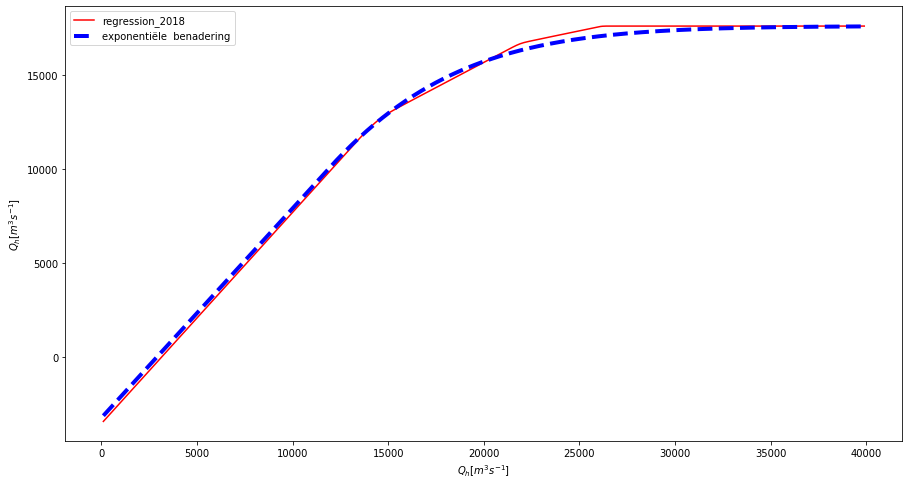

In [8]:
x = list(range(100,40000,100))
y = regression_2018(x)    
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x,y,'r-',label='regression_2018')
# ax1.plot(x,x,'--')
max_sbk=max(y)

# ax1.plot(ax1.get_xlim(),[max_sbk,max_sbk],'r--')
xx=np.array(x)
approx=np.array([forward(xi) for xi in xx])
ax1.plot(xx,approx,'b--',linewidth=4.0,label='exponentiële  benadering')
ax1.grid()
ax1.grid()
xlbl = ax1.set_xlabel('$Q_h [m^3 s^{-1}]$')
ylbl = ax1.set_ylabel('$Q_h [m^3 s^{-1}]$')
lgnd = ax1.legend()

Met de exponentiële benadering en inverse en afgeleiden kan de resulterende dichtheid voor de Sobek piekafvoer berekend worden, als de HBV piekafvoer $N(\mu,\sigma)$ verdeeld is: 

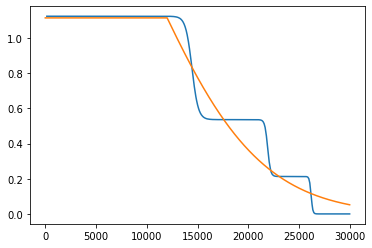

In [9]:
x = np.array(list(range(0,30000,25)))
y = np.array([diff_forward(xx) for xx in x]) 
y2 = np.array([interpolate(dydx['x'],dydx['dydx'],xx) for xx in x]) 
plt.plot(x,y2)
plt.plot(x,y)



In [10]:
def normpdf(xx,mu,sigma):
    return (1./(sigma*sqrt(2*pi))*np.exp(-(xx-mu)**2/2./sigma**2))

xrange = np.array(list(range(0,30000,25)))
mu0 = 20000
sigma0=1000
def update_transform(mu=widgets.FloatSlider(min=5000, max=26000, step=100, value=mu0, continuous_update=False, description='$\mu$'),sgm=widgets.FloatSlider(min=200, max=10000, step=50, value=sigma0, continuous_update=False, description='$\sigma$')):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    xpdf = normpdf(xrange,mu,sgm)
    xrange2 = xrange[xrange<max_sbk]
    ax1.plot(xrange,xpdf,'-',label='HBV')
    if False:
        ypdf = normpdf(np.array([inverse(xx) for xx in xrange2]),mu,sgm) #*np.array([diff_inverse(xx) for xx in xrange2])
        ypdf = ypdf*np.array([diff_inverse(xx) for xx in xrange2])
        ax1.plot(xrange2,ypdf,'-',label='SOBEK')
    else:
        ypdf = normpdf(np.array([inverse(xx) for xx in xrange]),mu,sgm) #*np.array([diff_inverse(xx) for xx in xrange2])
        ypdf = ypdf*np.array([diff_inverse(xx) for xx in xrange])
        ax1.plot(xrange,ypdf,'-',label='SOBEK')
    ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'g--')
    ax1.plot(np.array([25000,25000]),np.array([0,normpdf(25000,mu,sgm)]),'r--')
    
    xtail=xrange[xrange>25000]
    ytail=xpdf[xrange>25000]
    ax1.fill_between(xtail,0,ytail)
    lgnd=ax1.legend()
    ax1.set_title('Transformatie van de dichtheid onder de explonentiële benadering')
    
    return ax1
interact(update_transform)

interactive(children=(FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, m…

<function __main__.update_transform(mu=FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, min=5000.0, step=100.0), sgm=FloatSlider(value=1000.0, continuous_update=False, description='$\\sigma$', max=10000.0, min=200.0, step=50.0))>

In [11]:
def normpdf(xx,mu,sigma):
    return (1./(sigma*sqrt(2*pi))*np.exp(-(xx-mu)**2/2./sigma**2))

xrange = np.array(list(range(0,30000,25)))
mu0 = 20000
sigma0=1000
def update_transform2(mu=widgets.FloatSlider(min=5000, max=26000, step=100, value=mu0, continuous_update=False, description='$\mu$'),sgm=widgets.FloatSlider(min=200, max=10000, step=50, value=sigma0, continuous_update=False, description='$\sigma$')):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    xpdf = normpdf(xrange,mu,sgm)
    xrange2 = xrange[xrange<max_sbk]
    ypdf = np.array([normpdf(interpolate(y_sbk,x_hbv,yy),mu,sgm) for yy in xrange2])
    ypdf = ypdf * np.array([interpolate(dxdy['y'],dxdy['dxdy'],yy) for yy in xrange2]) 
        
    ax1.plot(xrange,xpdf,'-',label='HBV')
    ax1.plot(xrange2,ypdf,'-',linewidth=4.0,label='SOBEK')
    ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'g--')
    ax1.plot(np.array([25000,25000]),np.array([0,normpdf(25000,mu,sgm)]),'r--')
    
    xtail=xrange[xrange>25000]
    ytail=xpdf[xrange>25000]
    ax1.fill_between(xtail,0,ytail)
    lgnd=ax1.legend()
    ax1.set_title('Transformatie van de dichtheid onder regression_2018')
    
    return ax1
interact(update_transform2)

interactive(children=(FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, m…

<function __main__.update_transform2(mu=FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, min=5000.0, step=100.0), sgm=FloatSlider(value=1000.0, continuous_update=False, description='$\\sigma$', max=10000.0, min=200.0, step=50.0))>

In [13]:
x = list(range(100,40000,100))
y = regression_2018(x)    
max_sbk=max(y)
xx=np.array(x)
approx=np.array([forward(xi) for xi in xx])

def normpdf(xx,mu,sigma):
    return (1./(sigma*sqrt(2*pi))*np.exp(-(xx-mu)**2/2./sigma**2))

xrange = np.array(list(range(0,30000,25)))
mu0 = 20000
sigma0=1000

mu1    = 14442.2780 #ORIG
mu2    = 18573.2200 #ORIG
mu3    = 21904.1250 #ORIG
mu4    = 26177.6500 #ORIG



def update_transform4(mu=widgets.FloatSlider(min=5000, max=26000, step=100, value=mu0, continuous_update=False, description='$\mu$'),sgm=widgets.FloatSlider(min=200, max=10000, step=50, value=sigma0, continuous_update=False, description='$\sigma$')):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    ax3 = ax1.twiny()

    ax1.plot(x,y,'r-',label='regression_2018')
    ax1.plot(xx,approx,'b--',linewidth=4.0,label='exponentiële  benadering')

    plot_levels = True        

    ax3.set_xlim(0,0.0013)
    ax3.set_ylim(ax1.get_ylim())
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(0,0.0005)
    xpdf = normpdf(xrange,mu,sgm)
    
    xrange2 = xrange[xrange<max_sbk]
    ypdf_a = normpdf(np.array([inverse(xx) for xx in xrange2]),mu,sgm) #*np.array([diff_inverse(xx) for xx in xrange2])
    ypdf_a = ypdf_a*np.array([diff_inverse(xx) for xx in xrange2])
    ypdf_b = np.array([normpdf(interpolate(y_sbk,x_hbv,yy),mu,sgm) for yy in xrange2])
    ypdf_b = ypdf_b * np.array([interpolate(dxdy['y'],dxdy['dxdy'],yy) for yy in xrange2]) 
        
    ax2.plot(xrange,xpdf,'-',label='HBV')
    ax3.plot(ypdf_a,xrange2,'-',linewidth=4.0,label='SOBEK')
    ax3.plot(ypdf_b,xrange2,'-',linewidth=4.0,label='SOBEK')
    ax2.plot(np.array([25000,25000]),np.array([0,normpdf(25000,mu,sgm)]),'r--')
    ax3.plot(ax1.get_xlim(),[max_sbk,max_sbk],'g--')
    if plot_levels:
        ax3.plot(ax1.get_xlim(),[mu1,mu1],'c--')
        ax3.plot(ax1.get_xlim(),[mu2,mu2],'c--')
        ax3.plot(ax1.get_xlim(),[mu3,mu3],'c--')
        ax3.plot(ax1.get_xlim(),[mu4,mu4],'c--')

    
    xtail=xrange[xrange>25000]
    ytail=xpdf[xrange>25000]
    ax2.fill_between(xtail,0,ytail)
    ax1.set_title('Transformatie van de dichtheid onder regression_2018')

    xlbl = ax1.set_xlabel('$Q_h [m^3 s^{-1}]$')
    ylbl = ax1.set_ylabel('$Q_h [m^3 s^{-1}]$')
    # lgnd = ax1.legend()
    return ax1

interact(update_transform4)    

interactive(children=(FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, m…

<function __main__.update_transform4(mu=FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, min=5000.0, step=100.0), sgm=FloatSlider(value=1000.0, continuous_update=False, description='$\\sigma$', max=10000.0, min=200.0, step=50.0))>

In [78]:
def normpdf(xx,mu,sigma):
    return (1./(sigma*sqrt(2*pi))*np.exp(-(xx-mu)**2/2./sigma**2))

xrange = np.array(list(range(0,30000,25)))
mu0 = 20000
sigma0=1000
def update_transform2(mu=widgets.FloatSlider(min=5000, max=26000, step=100, value=mu0, continuous_update=False, description='$\mu$'),sgm=widgets.FloatSlider(min=200, max=10000, step=50, value=sigma0, continuous_update=False, description='$\sigma$')):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    xpdf = normpdf(xrange,mu,sgm)
    xrange2 = xrange[xrange<max_sbk]
    ypdf = np.array([normpdf(interpolate(y_sbk,x_hbv,yy),mu,sgm) for yy in xrange2])
    ypdf = ypdf * np.array([interpolate(dxdy['y'],dxdy['dxdy'],yy) for yy in xrange2]) 
        
    ax1.plot(xrange,xpdf,'-',label='HBV')
    ax1.plot(xrange2,ypdf,'-',linewidth=4.0,label='SOBEK')
    ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'g--')
    ax1.plot(np.array([25000,25000]),np.array([0,normpdf(25000,mu,sgm)]),'r--')
    
    xtail=xrange[xrange>25000]
    ytail=xpdf[xrange>25000]
    ax1.fill_between(xtail,0,ytail)
    lgnd=ax1.legend()
    ax1.set_title('Transformatie van de dichtheid onder regression_2018')
    
    return ax1
interact(update_transform2)

nx0=10000
nbin0=1000

def update_histogram(mu_hbv=widgets.FloatSlider(min=10000, max=25000, step=500, value=15000, continuous_update=False),sigma_hbv=widgets.FloatSlider(min=100, max=10000, step=500, value=1000, continuous_update=False)):
    nx = nx0
    nbin = nbin0
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    q_hbv=np.random.normal(mu_hbv,sigma_hbv,nx)
    q_sbk=regression_2018(q_hbv)
    result_hbv = ax1.hist(q_hbv, bins = nbin, density=True)
    result_sbk = ax1.hist(q_sbk, bins = nbin, density=True)
    ax1.set_xlim(9000,35000)
    ax1.set_ylim(0,0.00012)
#   ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'r--')
    print(sum(result_hbv[0]))
    return (ax1)
    
interact(update_histogram)

interactive(children=(FloatSlider(value=20000.0, continuous_update=False, description='$\\mu$', max=26000.0, m…

interactive(children=(FloatSlider(value=15000.0, continuous_update=False, description='mu_hbv', max=25000.0, m…

<function __main__.update_histogram(mu_hbv=FloatSlider(value=15000.0, continuous_update=False, description='mu_hbv', max=25000.0, min=10000.0, step=500.0), sigma_hbv=FloatSlider(value=1000.0, continuous_update=False, description='sigma_hbv', max=10000.0, min=100.0, step=500.0))>

In [82]:
# Load ensembles into dictionaries
# Read the file into a dictionary, labelled by event->timeseries
datafile = 'read_Qmax_sums_results.csv'
sep = ';'
with open(datafile,"r") as fnin:
    line = fnin.readline().strip()
    colnames = re.sub(r'[^\x00-\x7F]','', line).split(sep)
    ensembles = { colname:[] for colname in colnames}
    while line:
        line = fnin.readline()
        linesplit = line.strip().split(sep)
        for i in range(len(linesplit)):
            if linesplit[i]:
                try:
                    ensembles[colnames[i]].append(float(linesplit[i].replace(',','.')))
                except:
                    ensembles[colnames[i]].append(linesplit[i])


In [83]:
# Select realizations from ensembles:
first_realization = 0
last_realization = 100
refnr = 113

label2nr = {}
rownames = ensembles['Scenario']
for i in range(len(rownames)):
    label2nr[rownames[i]] = i
selected = ['Sum%d'%dd for dd in range (first_realization,last_realization+1)]    # selected labels for realizations
selnr = [label2nr[rowname] for rowname in selected]

In [85]:
# Determine min, max, alpha, beta for each ensemble
irow_ref = label2nr['Sum%d'%refnr]
results_m = {}
for icol in range(1,len(colnames)): 
    standard=ensembles[colnames[icol]][irow_ref]
    sample=np.array([ensembles[colnames[icol]][i] for i in selnr])
    est,var = fb.fitBetaMomentsJack(sample)
    results_m[colnames[icol]]={'estimate': est, 'variance':var, 'standard': standard}
    # print ens

In [86]:
a = np.array([])
b = np.array([])
alpha = np.array([])
beta = np.array([])
std = np.array([])

a_2se = np.array([])
b_2se = np.array([])
alpha_2se = np.array([])
beta_2se = np.array([])

lbl = []
for label in results_m.keys():
    std = np.append(std,results_m[label]['standard'])
    alpha = np.append(alpha,results_m[label]['estimate'][2])
    beta = np.append(beta,results_m[label]['estimate'][3])
    a = np.append(a,results_m[label]['estimate'][0])
    b = np.append(b,results_m[label]['estimate'][1])
    alpha_2se = np.append(alpha,results_m[label]['variance'][2])
    beta_2se = np.append(beta,results_m[label]['variance'][3])
    a_2se = np.append(a,results_m[label]['variance'][0])
    b_2se = np.append(b,results_m[label]['variance'][1])
    lbl.append(label)


In [100]:
ensemble_abcissa = np.array([])
ensemble_ordinate = np.array([])
ensemble_names=[key for key in ensembles.keys()]
for i in range(1,len(ensemble_names)):
    for ensemble_value in ensembles[ensemble_names[i]]:
        ensemble_abcissa = np.append(ensemble_abcissa,std[i-1])
        ensemble_ordinate = np.append(ensemble_ordinate,ensemble_value)
q_hbv_ensemble = np.array([interpolate(y_sbk,x_hbv,q_sbk) for q_sbk in ensemble_abcissa])

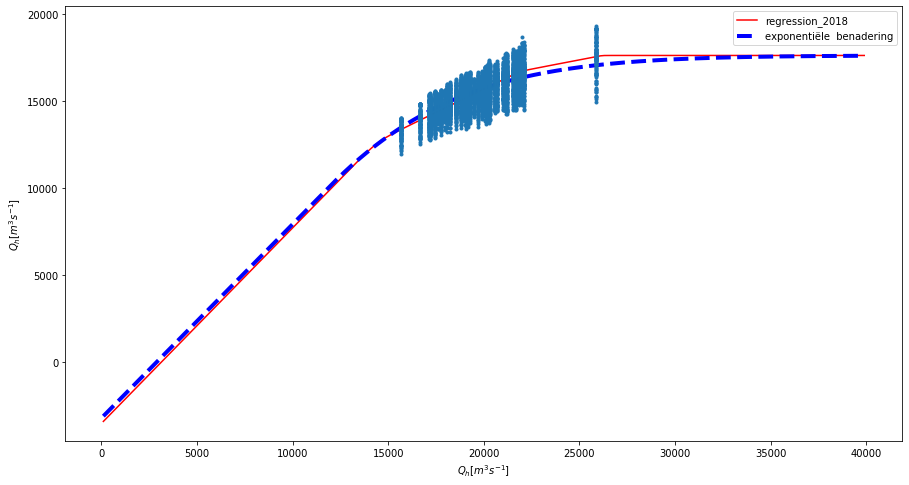

In [103]:
x = list(range(100,40000,100))
y = regression_2018(x)    
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x,y,'r-',label='regression_2018')
# ax1.plot(x,x,'--')
max_sbk=max(y)

# ax1.plot(ax1.get_xlim(),[max_sbk,max_sbk],'r--')
xx=np.array(x)
approx=np.array([forward(xi) for xi in xx])
ax1.plot(xx,approx,'b--',linewidth=4.0,label='exponentiële  benadering')
ax1.plot(q_hbv_ensemble,ensemble_ordinate,'.')
# ax1.set_xlim(12000,17000)
# ax1.set_ylim(10000,20000)
ax1.grid()
ax1.grid()
xlbl = ax1.set_xlabel('$Q_h [m^3 s^{-1}]$')
ylbl = ax1.set_ylabel('$Q_h [m^3 s^{-1}]$')
lgnd = ax1.legend()

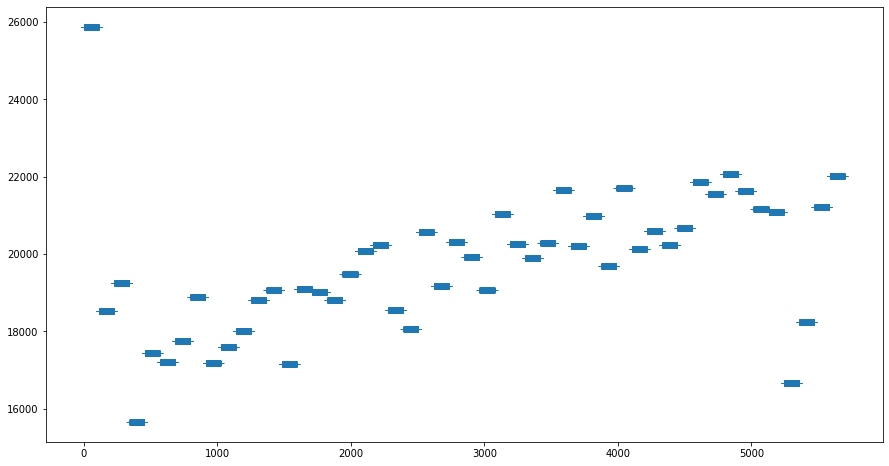

In [110]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(q_hbv_ensemble,'+')


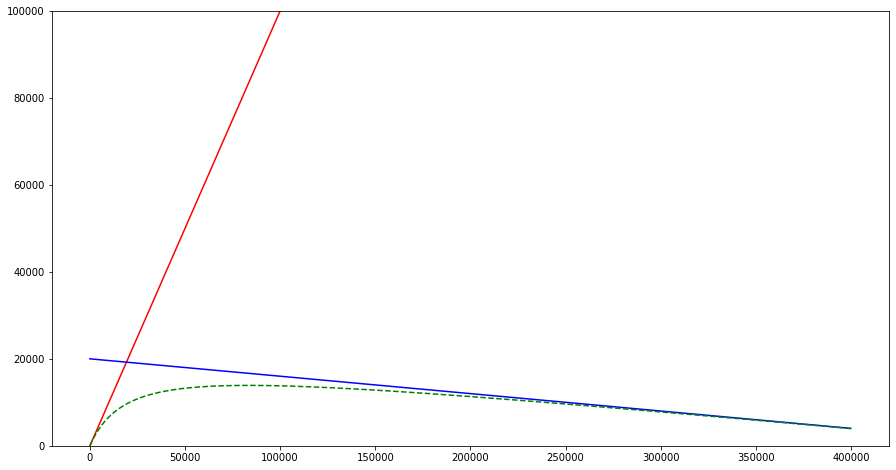

In [80]:
# straight lines aproximation:
a = 1                             # for small x: ax + b
b = 2
c = -0.04                          # for large x: cx + d
d = 20000
x = np.array(list(range(0,400000,100)))
y1 = a*x + b
y2 = c*x + d
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(x,y1,'r-')
ax1.plot(x,y2,'b-')

e21 = c
e22 = d
e11 = a + (a/d)*(b/(1.-b/d))
e12 = (b/(1.-b/d))

y3 = (e11*x + e12)/(1.+(e11*x + e12)/(e21*x + e22))
ax1.plot(x,y3,'g--')
ax1.set_ylim(0,100000)

xs = (d-b)/(a-c)
alp=0.001
y5 = []
for xx in x:
    y5.append((np.exp(alp*(xx-xs))*(a*x+b)+np.exp(alp*(xs-xx))*(c*x+d))/(exp(alp*(xx-xs))+exp(alp*(xs-xx))))
#ax1.plot(x,np.array(y5),'c--')

In [51]:
a=[2,1,3]
a.sort()

In [52]:
a

[1, 2, 3]

In [136]:
1100000**(2./3.)

10656.0223676661

In [23]:
x=np.array(list(range(10)))**2.

In [28]:
(x[1:]+x[:-1])*0.5

array([ 0.5,  2.5,  6.5, 12.5, 20.5, 30.5, 42.5, 56.5, 72.5])